# Musculoskeletal modeling and simulation

> Marcos Duarte  
> Laboratory of Biomechanics and Motor Control ([http://demotu.org/](http://demotu.org/))  
> Federal University of ABC, Brazil

We will now simulate the dynamics of the musculoskeletal system with muscle dynamics. You should have read [Muscle modeling](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleModeling.ipynb) and [Muscle simulation](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleSimulation.ipynb). In addition, chapter 4 of Nigg and Herzog (2006) is a good introduction to this topic.   

Let's start with the simplest case, a one-link rigid body with one degree of freedom and one muscle. 

## One-link system with one DoF and one muscle

Let's simulate the extension movement of the knee. This problem is based on an example from chapter 4 of Nigg and Herzog (2006). We will model the task as a planar movement, the leg and foot as one rigid segment and the rest of the body fixed, the knee as a revolute joint with fixed axis of rotation and one degree of freedom, and only one muscle as knee extensor, as illustrated in the figure below.  

<figure><img src="./../images/knee.png" alt="Planar knee model."/><figcaption><i><center>Figure. Planar model of the knee with one degree of freedom, one extensor muscle, and the corresponding free-body diagram for the leg. $\theta$: knee angle with horizontal; $F_M$ force of the quadriceps muscle; $F_J$: force at the knee joint; $r_M$: moment arm of the quadriceps; $r_{cm}$: distance to the knee joint of the center of mass of the leg+foot segment; $mg$: weight of the leg+foot; $L_{MT0}$: muscle-tendon unit length at $\theta=90^o$.</center></i></figcaption> 

From figure above, the Newton-Euler equation for the sum of moment of forces around the knee joint is:

$$ r_M F_M + r_{cm}\cos(\theta)mg = I\frac{\mathrm{d}^2 \theta}{\mathrm{d}t^2} $$

Where $I$ is the rotational inertia of the leg+foot segment around the knee joint.  
In our convention, the first term on the left-hand side is a positive (extensor) moment of force and the second term is a negative (flexor) moment of force when $\theta$ is greater than $90^o$. The Newton-Euler equation above is a second-order nonlinear differential equation.

In a typical movement analysis using inverse dynamics, we would measure the leg and thigh positions, calculate the leg and knee linear and angular position and acceleration, and then estimate the net moment of force at the knee joint and force of the quadriceps muscle using the equation above. Now, we want to perform forward dynamics, i.e., muscle force will be the input and the movement of the leg will be the output. The figure below compares the forward (direct) and inverse dynamics approaches.

<figure><img src="./../images/InvDirDyn.png" alt="Forward and inverse dynamics."/><figcaption><i><center>Figure. Inverse dynamics and Forward (or Direct) dynamics approaches for movement analysis (adapted from Zajac and Gordon, 1989).</center></i></figcaption>

The dependence of the length of the quadriceps muscle-tendon unit with the knee angle is given by:

$$ L_{MT} = L_{MT0} - r_m (\theta - \pi/2) $$

Examining the equations above, if we excite the muscle, it will generate force which will be transmitted to the leg segment and accelerate it, which in turn will vary the muscle length and velocity, affecting the muscle force. We already have seen that muscle force is related to muscle length and velocity by a first-order ODE (see [Muscle simulation](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleSimulation.ipynb)). So, muscle force and joint angle are described by two coupled ODEs. Mathematically, this means that the musculoskeletal system we modeled has as state variables: $L_M$, $\dot{L}_M$, and $\theta$ (and muscle activation $a$ could also be considered as a state variable in certain situations, but not for the present problem, where we consider it as an input parameter). Let's rewrite the Newton-Euler equation in a more clear form:

$$ \frac{\mathrm{d}^2 \theta}{\mathrm{d}t^2} = I^{-1} \left[ r_M F_M + r_{cm}\cos(\theta)mg \right] $$

$F_M$ will be determined when $L_M$ is calculated, which according to the muscle model we used in [Muscle simulation](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MuscleSimulation.ipynb) is the solution of the following first-order ODE:

$$ \frac{\mathrm{d} L_M}{\mathrm{d}t} = f_v^{-1}\left(\frac{F_{SE}(L_{MT}-L_M\cos\alpha)/\cos\alpha - F_{PE}(L_M)}{a f_l(L_M)}\right) $$

And:

$$ F_M = F_{SE}(L_{MT}-L_M\cos\alpha)/\cos\alpha $$

To apply numerical methods to solve these coupled equations, we have to express them as a system of first-order differential equations (see [Ordinary differential equation](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/OrdinaryDifferentialEquation.ipynb)):

$$ \left\{
\begin{array}{l l}
\frac{\mathrm{d} L_M}{\mathrm{d}t} = & f^{-1}_{v}(L_M(\theta)), \quad &L_M(t_0) = L_{M0}
\\
\frac{\mathrm{d} \theta}{\mathrm{d}t} = &\omega, \quad &\theta(t_0) = \theta
\\
\frac{\mathrm{d} \omega}{\mathrm{d}t} = &I^{-1} \left[ r_M F_M(L_M(\theta)) + r_{cm}\cos(\theta)mg \right], \quad &\omega(t_0) = \omega_0
\end{array}
\right.$$

Let's solve this problem in Python.  
First, let's import the necessary Python libraries and customize the environment:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.size'] = 13
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rc('axes', grid=False, labelsize=14, titlesize=16, ymargin=0.05)
matplotlib.rc('legend', numpoints=1, fontsize=11)
from scipy.integrate import odeint, ode
# import the muscles.py module
import sys
sys.path.insert(1, r'./../functions')
import muscles

Let's define a function with the system of first-order ODEs:

In [2]:
def onelink_eq(lmthetaomega, t):
    """equation for one-link system."""
    
    # parameters from Nigg and Herzog (2006)
    lmt0 = 0.310
    rm   = 0.033
    rcm  = 0.264
    m    = 10
    g    = 9.8
    I    = 0.1832
    
    lm      = lmthetaomega[0]  # muscle length
    theta   = lmthetaomega[1]  # knee position 
    omega   = lmthetaomega[2]  # knee velocity
    lmt     = lmt0 - rm_fun(theta)*(theta - np.pi/2)
    lmd     = fv_1_eq(t, lm, lmt)
    thetadd = (rm_fun(theta)*fm_eq(lm, lmd, lmt) + rcm*np.cos(theta)*m*g)/I  # acceleration
    
    return [lmd, omega, thetadd]

In [3]:
# define a function for the moment arm
def rm_fun(theta):
    """Vastus intermedius moment arm."""
    
    rm = 0.033
    
    return rm

Functions to calculate the force-velocity relationship:

In [4]:
def fv_1_eq(t, lm, lmt):
    
    lmopt = ms.P['lmopt']
    ltslack = ms.P['ltslack']
    a = 1
    alpha = 0
    if lm < 0.1*lmopt:
        lm = 0.1*lmopt

    lt    = lmt - lm*np.cos(alpha)
    fse   = ms.force_se(lt=lt, ltslack=ltslack)
    fpe   = ms.force_pe(lm=lm/lmopt)
    fl    = ms.force_l(lm=lm/lmopt)
    fce_t = fse/np.cos(alpha) - fpe
    vm    = ms.velo_fm(fm=fce_t, a=a, fl=fl)

    return vm    


def fm_eq(lm, lmd, lmt):
    
    fm0  = ms.P['fm0']
    lmopt = ms.P['lmopt']
    ltslack = ms.P['ltslack']
    a = 1
    alpha = 0

    lt = lmt - lm*np.cos(alpha)
    fl = ms.force_l(lm=lm/lmopt)
    fpe = ms.force_pe(lm=lm/lmopt)
    fm = ms.force_vm(vm=lmd, fl=fl, lmopt=lmopt, a=a) + fpe 
    fm = fm*fm0
    
    return fm

Let's instantiate the `muscles` class:

The parameters were successfully loaded and are stored in the variable P.
The states were successfully loaded and are stored in the variable S.


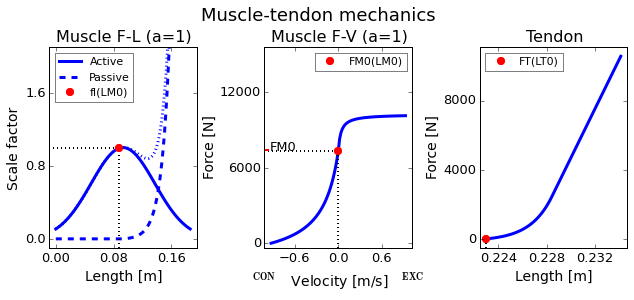

In [5]:
ms = muscles.Thelen2003()
ms.set_parameters()
ms.set_states()
ms.muscle_plot();

Let's input the initial states and use `scipy.odeint` to solve the ODEs:

In [6]:
lmthetaomega = [0.087, np.pi/2, 0]
time = np.arange(0, .12, 0.001)
data  = odeint(onelink_eq, lmthetaomega, time)

Plots of the simulated angular position and velocity:

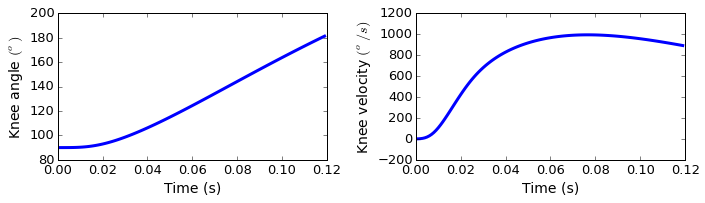

In [7]:
def sim_plot(time, data, ms):

    datam = []
    for i, t in enumerate(time):
        fm0  = ms.P['fm0']
        lmopt = ms.P['lmopt']
        ltslack = ms.P['ltslack']
        a = 1
        alpha = 0
        lmt0 = 0.310

        lm = data[i, 0]
        theta = data[i, 1]
        lmt = lmt0 - rm_fun(theta)*(theta - np.pi/2)
        lt = lmt - lm*np.cos(alpha)
        fl = ms.force_l(lm=lm/lmopt)
        fpe = ms.force_pe(lm=lm/lmopt)
        fse = ms.force_se(lt=lt, ltslack=ltslack)
        fce_t = fse/np.cos(alpha) - fpe
        vm = ms.velo_fm(fm=fce_t, a=a, fl=fl, lmopt=lmopt)
        fm = ms.force_vm(vm=vm, fl=fl, lmopt=lmopt, a=a) + fpe   
        d = [t, lmt, lm, lt, vm, fm*fm0, fse*fm0, a*fl*fm0, fpe*fm0, alpha]
        datam.append(d)

    datam = np.array(datam)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex = True, figsize=(10, 3))
    axs[0].plot(time, data[:, 1]*180/np.pi)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Knee angle $(^o)$')
    axs[1].plot(time, data[:, 2]*180/np.pi)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Knee velocity $(^o/s)$')
    plt.tight_layout()
    plt.show()
    
    return axs, datam

axs, data2 = sim_plot(time, data, ms)

And the plots for the simulated muscle mechanics:

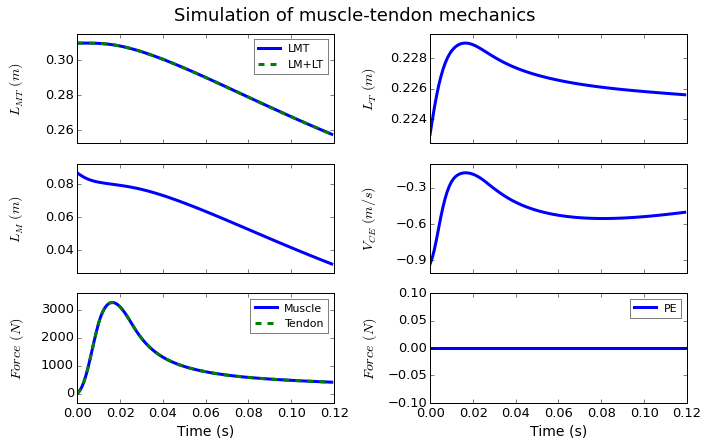

In [8]:
axs_lm = ms.lm_plot(data2)

### Moment arm is not constant

In fact, knee moment arms of the knee extensors are not constant and change with the knee angle. We can import these data from [OpenSim](http://web.stanford.edu/group/opensim/index.html). Here is the data for the vastus intermedius moment arm:

In [9]:
vas_int_r = np.loadtxt('./../data/vas_int_r.mot', skiprows=7)
print('Shape of vas_int_r:', vas_int_r.shape)

Shape of vas_int_r: (100, 3)


We need to be able to calculate the moment arm for any angle, not only for the 100 values in these data. Let's fit a spline to these data, which will return a function we can use to calculate the moment arm at any angle:

In [10]:
from scipy import interpolate
S = interpolate.InterpolatedUnivariateSpline(vas_int_r[:, 1], vas_int_r[:, 2])

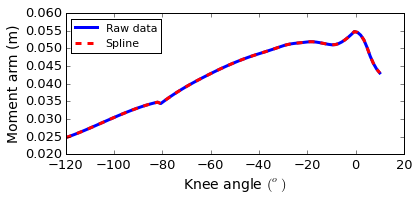

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(vas_int_r[:, 1], vas_int_r[:, 2], label='Raw data')
ax.plot(vas_int_r[:, 1], S(vas_int_r[:, 1]), 'r--', label='Spline')
ax.set_xlabel('Knee angle $(^o)$')
ax.set_ylabel('Moment arm (m)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

It works as expected, we just have to handle the fact that the angle range is different.  
Let's define a new function for the moment arm for our simulation:

In [12]:
# define a function for the moment arm
def rm_fun(theta, data=S):
    """Vastus intermedius moment arm."""
    
    rm = S(theta*np.pi/180 - np.pi)
    
    return rm

In [13]:
data = odeint(onelink_eq, lmthetaomega, time)

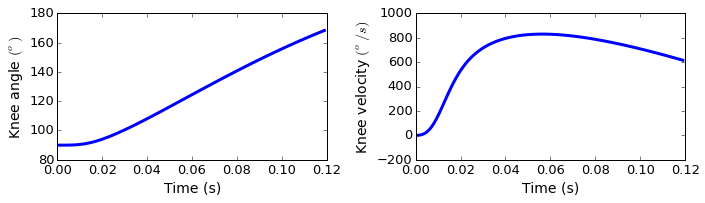

In [14]:
axs, data2 = sim_plot(time, data, ms)

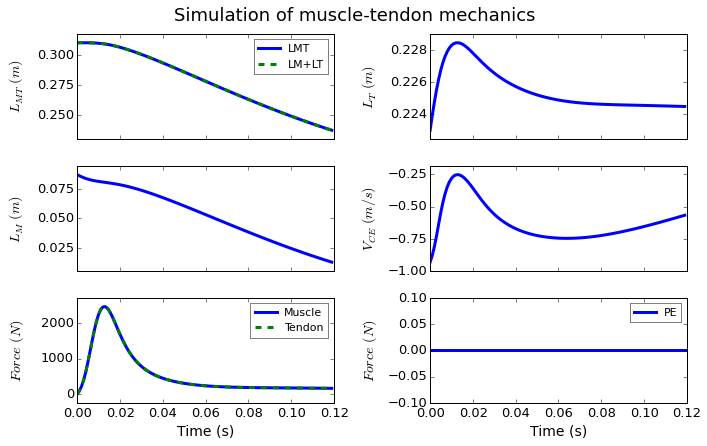

In [15]:
axs_lm2 = ms.lm_plot(data2)  # axs_lm

## References

- Nigg BM and Herzog W (2006) [Biomechanics of the Musculo-skeletal System](https://books.google.com.br/books?id=hOIeAQAAIAAJ&dq=editions:ISBN0470017678). 3rd Edition. Wiley.  
- Zajac FE, Gordon ME (1989) [Determining muscle's force and action in multi-articular movement](https://drive.google.com/open?id=0BxbW72zV7WmUcC1zSGpEOUxhWXM&authuser=0). Exercise and Sport Sciences Reviews, 17, 187-230.